In [375]:
# ！pip install functorch
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import pandas as pd
import scipy
from scipy import stats
import numpy as np
from os import path
import torchvision
import matplotlib.pyplot as plt

In [376]:
MA_DAYS = 25
trading_days_in_year = 252

# Import raw data from yahoo finance

In [377]:
from google.colab import drive
drive.mount('/content/drive')
data_files_path_prefix = "/content/drive/MyDrive"
data_files_path = "ML-Portfolio-Data"
data_files_path = path.join(data_files_path_prefix, data_files_path)

high_risk_file = 'SPY.csv'
low_risk_file = 'IEF.csv'
high_risk = pd.read_csv(path.join(data_files_path, high_risk_file))
low_risk = pd.read_csv(path.join(data_files_path, low_risk_file))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [378]:
# Read files from the same directory
#high_risk = pd.read_csv('SPY.csv')
#low_risk = pd.read_csv('IEF.csv')

In [379]:
print(high_risk.shape)
print(low_risk.shape)

(5147, 7)
(5147, 7)


In [380]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-07-30,89.320000,91.400002,88.720001,90.940002,61.380939,47532200
1,2002-07-31,90.489998,91.550003,89.250000,91.160004,61.529453,44669900
2,2002-08-01,90.879997,91.349998,88.330002,88.779999,59.923054,66571900
3,2002-08-02,88.500000,88.910004,85.620003,86.790001,58.579895,51772900
4,2002-08-05,86.489998,86.930000,83.550003,83.769997,56.541496,47191300


In [381]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-07-30,81.940002,82.120003,81.699997,81.769997,45.672558,41300
1,2002-07-31,82.050003,82.580002,82.050003,82.519997,46.091442,32600
2,2002-08-01,82.540001,82.900002,82.519997,82.860001,46.281376,71400
3,2002-08-02,83.019997,83.699997,82.900002,83.500000,46.638828,120300
4,2002-08-05,83.680000,83.919998,83.529999,83.919998,46.873459,159300


# Build Dataset for ML Portfolio

In [382]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

## Enrich data

### Calculate daily returns

In [383]:
def add_daily_return(market_data):
    market_data["Daily Return"]  = market_data['Close'] - market_data['Open']

add_daily_return(high_risk)
add_daily_return(low_risk)

### Calculate moving average (MA) of daily returns

In [384]:
def add_moving_average(market_data, ma_days):
    temp_vars = []

    # df = market_data
    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data[temp_var] = market_data["Daily Return"].shift(i)
        temp_vars.append(temp_var)

    market_data["MA"] = market_data[temp_vars].mean(axis=1)

    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data.drop(temp_var, axis = 1, inplace = True)

add_moving_average(high_risk, MA_DAYS)
add_moving_average(low_risk, MA_DAYS)


In [385]:
high_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
5142,2022-12-30,380.640015,382.579987,378.429993,382.429993,382.429993,83975100,1.789978,-0.368799
5143,2023-01-03,384.369995,386.429993,377.829987,380.820007,380.820007,74850700,-3.549988,-0.530798
5144,2023-01-04,383.179993,385.880005,380.000000,383.760010,383.760010,85934100,0.580017,-0.380398
5145,2023-01-05,381.720001,381.839996,378.760010,379.380005,379.380005,76970500,-2.339996,-0.441199
5146,2023-01-06,382.609985,389.250000,379.410004,388.079987,388.079987,104041300,5.470002,-0.709999


In [386]:
low_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
5142,2022-12-30,95.860001,96.269997,95.620003,95.779999,95.779999,5039800,-0.080002,0.050399
5143,2023-01-03,96.910004,97.000000,96.339996,96.529999,96.529999,6808300,-0.380005,0.025599
5144,2023-01-04,97.339996,97.419998,96.989998,97.269997,97.269997,7800100,-0.069999,0.025599
5145,2023-01-05,96.699997,97.220001,96.570000,97.129997,97.129997,3177900,0.430000,0.043600
5146,2023-01-06,97.169998,98.430000,97.080002,98.379997,98.379997,6807700,1.209999,0.050399


### Calculate ROE

In [387]:
def add_roe(market_data):    
    market_data["Next Close"] = market_data["Close"].shift(-1)
    market_data["ROE"] = (market_data["Next Close"] - market_data["Close"]) / market_data['Close']

add_roe(high_risk)
add_roe(low_risk)

In [388]:
def add_roe_binary(market_data, tau=-0.005):    
    market_data["ROE Binary"] = np.where(market_data["ROE"].values < tau, 0, 1)

add_roe_binary(high_risk)
add_roe_binary(low_risk)

In [389]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Next Close,ROE,ROE Binary
0,2002-07-30,89.320000,91.400002,88.720001,90.940002,61.380939,47532200,1.620002,1.620002,91.160004,0.002419,1
1,2002-07-31,90.489998,91.550003,89.250000,91.160004,61.529453,44669900,0.670006,1.145004,88.779999,-0.026108,0
2,2002-08-01,90.879997,91.349998,88.330002,88.779999,59.923054,66571900,-2.099998,0.063337,86.790001,-0.022415,0
3,2002-08-02,88.500000,88.910004,85.620003,86.790001,58.579895,51772900,-1.709999,-0.379997,83.769997,-0.034797,0
4,2002-08-05,86.489998,86.930000,83.550003,83.769997,56.541496,47191300,-2.720001,-0.847998,86.589996,0.033664,1


In [390]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Next Close,ROE,ROE Binary
0,2002-07-30,81.940002,82.120003,81.699997,81.769997,45.672558,41300,-0.170005,-0.170005,82.519997,0.009172,1
1,2002-07-31,82.050003,82.580002,82.050003,82.519997,46.091442,32600,0.469994,0.149994,82.860001,0.004120,1
2,2002-08-01,82.540001,82.900002,82.519997,82.860001,46.281376,71400,0.320000,0.206663,83.500000,0.007724,1
3,2002-08-02,83.019997,83.699997,82.900002,83.500000,46.638828,120300,0.480003,0.274998,83.919998,0.005030,1
4,2002-08-05,83.680000,83.919998,83.529999,83.919998,46.873459,159300,0.239998,0.267998,83.239998,-0.008103,0


## Build feature space

In [391]:
def remove_for_ma(market_data, ma_days):
  return market_data[ma_days:]

high_risk = remove_for_ma(high_risk, MA_DAYS)
low_risk = remove_for_ma(low_risk, MA_DAYS)

In [392]:
print(high_risk.shape)

(5122, 12)


In [393]:
def standardize_columns(market_data, columns):
  for column in columns:
    market_data[column] = market_data[column]/market_data[column].std()

standardize_columns(high_risk, ['Volume', 'Daily Return', 'MA'])
standardize_columns(low_risk, ['Volume', 'Daily Return', 'MA'])

<ipython-input-393-d0986728a5f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_data[column] = market_data[column]/market_data[column].std()


In [394]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Next Close,ROE,ROE Binary
25,2002-09-04,88.610001,90.250000,88.059998,89.540001,60.436001,0.550024,0.479605,0.276737,88.779999,-0.008488,0
26,2002-09-05,88.489998,89.430000,87.500000,88.779999,59.923054,0.723874,0.149555,0.229367,90.000000,0.013742,1
27,2002-09-06,89.750000,90.570000,89.339996,90.000000,60.746498,0.415721,0.128926,0.522307,90.660004,0.007333,1
28,2002-09-09,89.099998,91.349998,88.800003,90.660004,61.191929,0.365951,0.804501,0.929931,91.699997,0.011471,1
29,2002-09-10,91.139999,91.779999,90.559998,91.699997,61.893936,0.445799,0.288793,1.338801,91.129997,-0.006216,0


In [395]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Next Close,ROE,ROE Binary
25,2002-09-04,85.160004,85.449997,85.080002,85.199997,47.752071,0.023505,0.135391,0.912126,85.540001,0.003991,1
26,2002-09-05,85.599998,85.650002,85.190002,85.540001,47.942638,0.017606,-0.203112,0.564337,84.879997,-0.007716,0
27,2002-09-06,85.089996,85.250000,84.839996,84.879997,47.572742,0.009791,-0.710926,0.216542,84.760002,-0.001414,1
28,2002-09-09,84.940002,85.150002,84.750000,84.760002,47.505463,0.027002,-0.609368,-0.216563,85.059998,0.003539,1
29,2002-09-10,84.709999,85.209999,84.660004,85.059998,47.673588,0.006507,1.184878,-0.144378,84.750000,-0.003644,1


In [396]:
# def to_dataset(low_risk, high_risk):
#   return np.vstack((low_risk['Daily Return'], low_risk['MA'], low_risk['Volume'], high_risk['Daily Return'], high_risk['MA'], high_risk['Volume'],high_risk['ROE Binary']))

# dataset = to_dataset(low_risk, high_risk).T
# print(dataset.shape, dataset)

In [397]:
# pd.concat([low_risk, high_risk], join='outer', axis=1)[['Date'],['Daily Return'],['MA'],['Volume'],['ROE Binary']]
# pd.concat([low_risk.add_prefix('l_'), high_risk.add_prefix('h_')], join='outer', axis=1)[['Date','ROE Binary']]
ml_master_dataset = pd.concat([low_risk.add_prefix('l_'), high_risk.add_prefix('h_')], join='outer', axis=1)[['l_Date','l_Daily Return','l_MA','l_Volume','h_Daily Return','h_MA','h_Volume','h_ROE Binary']]
ml_master_dataset

,l_Date,l_Daily Return,l_MA,l_Volume,h_Daily Return,h_MA,h_Volume,h_ROE Binary
25,2002-09-04,0.135391,0.912126,0.023505,0.479605,0.276737,0.550024,0
26,2002-09-05,-0.203112,0.564337,0.017606,0.149555,0.229367,0.723874,1
27,2002-09-06,-0.710926,0.216542,0.009791,0.128926,0.522307,0.415721,1
28,2002-09-09,-0.609368,-0.216563,0.027002,0.804501,0.929931,0.365951,1
29,2002-09-10,1.184878,-0.144378,0.006507,0.288793,1.338801,0.445799,0
...,...,...,...,...,...,...,...,...
5142,2022-12-30,-0.270837,0.826825,1.532486,0.923099,-1.149319,0.903889,1
5143,2023-01-03,-1.286460,0.419968,2.070246,-1.830743,-1.654172,0.805676,1
5144,2023-01-04,-0.236973,0.419968,2.371829,0.299117,-1.185467,0.924976,0
5145,2023-01-05,1.455712,0.715269,0.966325,-1.206745,-1.374945,0.828493,1


In [398]:
# X_tensor = torch.from_numpy(ml_master_dataset[:,:-1])
# Y_tensor = torch.from_numpy(ml_master_dataset[:,-1])

## Build graph

In [399]:
lr = 1e-1
n_epochs = 500
torch.manual_seed(42)
lambda1 = 1e-3 #0.5
lambda2 = 1e-3 #0.5

loss_fn = nn.BCELoss()

batch_size = 32

In [400]:
folds=10
splits=KFold(n_splits=folds,shuffle=True,random_state=42)

In [401]:
#no cross-validation

def train_and_get_a_b(dataset):

  a = torch.randn((6), requires_grad=True, dtype=torch.double)
  b = torch.randn((6), requires_grad=True, dtype=torch.double)
  # print(a, a.size(), b, b.size())

  optimizer = optim.SGD([a, b], lr=lr)

  X_tensor = torch.from_numpy(dataset[:,:-1])
  Y_tensor = torch.from_numpy(dataset[:,-1])
  # print(X_tensor, Y_tensor)
    
    
  for epoch in range(n_epochs):
    
      yhat = torch.exp(torch.matmul(X_tensor, a)) / (torch.exp (torch.matmul(X_tensor, a)) + torch.exp(torch.matmul(X_tensor, b)))

      loss = loss_fn(yhat, Y_tensor)
      loss.backward()   

      if epoch % 10 == 0:
        print(f"Epoch: {epoch}. Loss: {loss}")

      optimizer.step()
      optimizer.zero_grad()
      
  return a,b

# Build Dataset for MV Portfolio

In [402]:
mv_master_dataset = pd.concat([low_risk.add_prefix('l_'), high_risk.add_prefix('h_')], join='outer', axis=1)[['l_Date','l_Close','h_Close']]
mv_master_dataset

,l_Date,l_Close,h_Close
25,2002-09-04,85.199997,89.540001
26,2002-09-05,85.540001,88.779999
27,2002-09-06,84.879997,90.000000
28,2002-09-09,84.760002,90.660004
29,2002-09-10,85.059998,91.699997
...,...,...,...
5142,2022-12-30,95.779999,382.429993
5143,2023-01-03,96.529999,380.820007
5144,2023-01-04,97.269997,383.760010
5145,2023-01-05,97.129997,379.380005


In [432]:
def get_mv_dataset_for_date(date):
  startdate = pd.to_datetime(date) - delta_50weeks
  enddate = pd.to_datetime(date)
  mask = (pd.to_datetime(mv_master_dataset['l_Date']) > startdate) & (pd.to_datetime(mv_master_dataset['l_Date']) <= enddate)
  subset = mv_master_dataset.loc[mask]
  dataset = subset[['l_Close','h_Close']]
  return dataset

In [404]:
def get_annual_sample_return_and_covariance(data):
    daily_return = data.pct_change()
    annual_return = daily_return.mean() * trading_days_in_year
    daily_covariance = daily_return.cov()
    annual_covariance = daily_covariance * trading_days_in_year
    return annual_return, annual_covariance

In [405]:
def get_sample_return_and_covariance(data):
    daily_return = data.pct_change().mean()
    daily_covariance = data.pct_change().cov()
    return daily_return, daily_covariance

In [406]:
def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = TERMINATION)
    
    return  opt

In [407]:
def get_mv_backtest_data(date):
  startdate = pd.to_datetime(date)
  enddate = pd.to_datetime(date) + delta_1week
    
  low_risk_mask = (pd.to_datetime(low_risk['Date']) > startdate) & (pd.to_datetime(low_risk['Date']) <= enddate)
  high_risk_mask = (pd.to_datetime(high_risk['Date']) > startdate) & (pd.to_datetime(high_risk['Date']) <= enddate)
  low_risk_backtest_data = low_risk.loc[low_risk_mask]
  high_risk_backtest_data = high_risk.loc[high_risk_mask]

  return low_risk_backtest_data, high_risk_backtest_data

In [408]:
def calculate_backtest_return(backtest_data):
  first_open = backtest_data.iloc[0]['Open']
  last_close = backtest_data.iloc[-1]['Close']
  return (last_close - first_open)/first_open

In [434]:
def calculate_mv_backtest_return(low_risk_backtest_data, high_risk_backtest_data, weight):
  low_return = calculate_backtest_return(low_risk_backtest_data)
  high_return = calculate_backtest_return(high_risk_backtest_data)
  return low_return * (1-weight) + high_return * weight

In [435]:
def get_mv_backtest_return(date, weight):
  low_risk_backtest_data, high_risk_backtest_data = get_mv_backtest_data(date)
  return calculate_mv_backtest_return(low_risk_backtest_data, high_risk_backtest_data, weight)

# Backtesting

In [411]:
import time
from datetime import date
from datetime import timedelta

In [412]:
first_date = date(2003,9,21)
last_date = date(2023,1,1)

In [413]:
delta_50weeks = timedelta(weeks=50)
delta_1week = timedelta(weeks=1)

In [414]:
daterange = pd.date_range(first_date, last_date, freq='1W')
daterange

DatetimeIndex(['2003-09-21', '2003-09-28', '2003-10-05', '2003-10-12',
               '2003-10-19', '2003-10-26', '2003-11-02', '2003-11-09',
               '2003-11-16', '2003-11-23',
               ...
               '2022-10-30', '2022-11-06', '2022-11-13', '2022-11-20',
               '2022-11-27', '2022-12-04', '2022-12-11', '2022-12-18',
               '2022-12-25', '2023-01-01'],
              dtype='datetime64[ns]', length=1007, freq='W-SUN')

In [415]:
def get_ml_dataset_for_date(date):
  startdate = pd.to_datetime(date) - delta_50weeks
  enddate = pd.to_datetime(date)
  mask = (pd.to_datetime(ml_master_dataset['l_Date']) > startdate) & (pd.to_datetime(ml_master_dataset['l_Date']) <= enddate)
  subset = ml_master_dataset.loc[mask]
  # print(subset)
  dataset = subset[['l_Daily Return','l_MA','l_Volume','h_Daily Return','h_MA','h_Volume','h_ROE Binary']].to_numpy()
  # print(dataset)
  return dataset

### First date

In [416]:
dataset = get_ml_dataset_for_date(first_date)
dataset[:-1]

array([[ 0.10155789,  1.89647755,  0.02441736, ..., -0.97480731,
         0.57250387,  1.        ],
       [ 0.40625526,  1.88335059,  0.04092873, ..., -0.59959326,
         0.8560541 ,  0.        ],
       [ 0.16925525,  1.88991473,  0.02873525, ..., -0.83893149,
         0.86063301,  1.        ],
       ...,
       [ 0.20311239,  0.702162  ,  0.02435655, ...,  0.53227856,
         0.40786757,  1.        ],
       [ 1.11718079,  1.03027115,  0.05385199, ...,  0.41510118,
         0.3432117 ,  1.        ],
       [-0.06772444,  1.33868853,  0.04019894, ...,  0.66191837,
         0.32553542,  0.        ]])

In [417]:
a,b = train_and_get_a_b(dataset[:-1])

Epoch: 0. Loss: 1.2250968985965647
Epoch: 10. Loss: 1.0422664556524388
Epoch: 20. Loss: 0.9103199651473237
Epoch: 30. Loss: 0.8211627365206585
Epoch: 40. Loss: 0.7621501754153689
Epoch: 50. Loss: 0.7225548587061368
Epoch: 60. Loss: 0.6954737927837602
Epoch: 70. Loss: 0.6767014150071979
Epoch: 80. Loss: 0.6635699476207669
Epoch: 90. Loss: 0.6543132706623938
Epoch: 100. Loss: 0.6477360885029361
Epoch: 110. Loss: 0.6430221585728905
Epoch: 120. Loss: 0.6396116532648428
Epoch: 130. Loss: 0.6371191459597229
Epoch: 140. Loss: 0.635278073957452
Epoch: 150. Loss: 0.6339030752274836
Epoch: 160. Loss: 0.6328644511700781
Epoch: 170. Loss: 0.6320708338895114
Epoch: 180. Loss: 0.6314573915018703
Epoch: 190. Loss: 0.6309777707686528
Epoch: 200. Loss: 0.6305985665087154
Epoch: 210. Loss: 0.6302955051416969
Epoch: 220. Loss: 0.6300507962110538
Epoch: 230. Loss: 0.6298512837528443
Epoch: 240. Loss: 0.6296871483410416
Epoch: 250. Loss: 0.6295509903413822
Epoch: 260. Loss: 0.6294371785102312
Epoch: 270. L

In [418]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(torch.from_numpy(dataset[-1][:-1]), a)) / (torch.exp (torch.matmul(torch.from_numpy(dataset[-1][:-1]), a)) + torch.exp(torch.matmul(torch.from_numpy(dataset[-1][:-1]), b)))
  print(y_test)

tensor(0.6920, dtype=torch.float64)


In [419]:
def calculate_ml_portfolio_weights(x, k):
  return 0 if x < k else 1

In [420]:
weight = calculate_ml_portfolio_weights(y_test.numpy(), 0.5)
weight

1

In [421]:
def get_backtest_data(date, weight):
  startdate = pd.to_datetime(date)
  enddate = pd.to_datetime(date) + delta_1week

  investment = low_risk if weight == 0 else high_risk
    
  backtest_mask = (pd.to_datetime(investment['Date']) > startdate) & (pd.to_datetime(investment['Date']) <= enddate)
  backtest_data = investment.loc[backtest_mask]

  return backtest_data

In [422]:
def calculate_backtest_return(backtest_data):
  first_open = backtest_data.iloc[0]['Open']
  last_close = backtest_data.iloc[-1]['Close']
  return (last_close - first_open)/first_open

In [423]:
def get_backtest_return(date, weight):
  backtest_data = get_backtest_data(date, weight)
  return calculate_backtest_return(backtest_data)

In [424]:
backtest_data = get_backtest_data(first_date, weight)
backtest_data.iloc[-1]['Close']
backtest_data.iloc[0]['Open']

102.849998

In [425]:
get_backtest_return(first_date, weight)

-0.028196412799152443

## Back test for all range

### ML Portfolio

In [426]:
parameters = pd.DataFrame(columns=['a','b','prob'])

for date in daterange:
  print(date)
  dataset = get_ml_dataset_for_date(date)
  a,b = train_and_get_a_b(dataset[:-1])  
  with torch.no_grad():
    y_test = torch.exp(torch.matmul(torch.from_numpy(dataset[-1][:-1]), a)) / (torch.exp (torch.matmul(torch.from_numpy(dataset[-1][:-1]), a)) + torch.exp(torch.matmul(torch.from_numpy(dataset[-1][:-1]), b)))
    print(y_test)
    parameters.loc[date] = [a,b,y_test.numpy()]

parameters

Streaming output truncated to the last 5000 lines.
Epoch: 430. Loss: 0.579132914685977
Epoch: 440. Loss: 0.5791325550558514
Epoch: 450. Loss: 0.5791322520808101
Epoch: 460. Loss: 0.5791319968279854
Epoch: 470. Loss: 0.5791317817747692
Epoch: 480. Loss: 0.5791316005857305
Epoch: 490. Loss: 0.5791314479249337
tensor(0.9898, dtype=torch.float64)
2021-03-07 00:00:00
Epoch: 0. Loss: 1.6926048258833029
Epoch: 10. Loss: 1.371197322306517
Epoch: 20. Loss: 1.0853757657759322
Epoch: 30. Loss: 0.8623561998168796
Epoch: 40. Loss: 0.7184527421792531
Epoch: 50. Loss: 0.6469919017243319
Epoch: 60. Loss: 0.6177306557360324
Epoch: 70. Loss: 0.6054786742592019
Epoch: 80. Loss: 0.5991356739487206
Epoch: 90. Loss: 0.595038311464021
Epoch: 100. Loss: 0.5920230840235082
Epoch: 110. Loss: 0.589665925157147
Epoch: 120. Loss: 0.5877718507898121
Epoch: 130. Loss: 0.5862286032547389
Epoch: 140. Loss: 0.5849609049906295
Epoch: 150. Loss: 0.5839138457646948
Epoch: 160. Loss: 0.5830455657630869
Epoch: 170. Loss: 0.

,a,b,prob
2003-09-21,"[tensor(0.0821, dtype=torch.float64, grad_fn=<...","[tensor(0.2624, dtype=torch.float64, grad_fn=<...",0.67439726413072
2003-09-28,"[tensor(0.0449, dtype=torch.float64, grad_fn=<...","[tensor(0.2281, dtype=torch.float64, grad_fn=<...",0.7049454524952933
2003-10-05,"[tensor(-0.3851, dtype=torch.float64, grad_fn=...","[tensor(-0.2060, dtype=torch.float64, grad_fn=...",0.7705497222091419
2003-10-12,"[tensor(-2.2452, dtype=torch.float64, grad_fn=...","[tensor(-2.0383, dtype=torch.float64, grad_fn=...",0.6773620347956015
2003-10-19,"[tensor(-0.1125, dtype=torch.float64, grad_fn=...","[tensor(0.0835, dtype=torch.float64, grad_fn=<...",0.7100869972302286
...,...,...,...
2022-12-04,"[tensor(-0.2526, dtype=torch.float64, grad_fn=...","[tensor(-0.0017, dtype=torch.float64, grad_fn=...",0.7126808019883828
2022-12-11,"[tensor(0.1450, dtype=torch.float64, grad_fn=<...","[tensor(0.3640, dtype=torch.float64, grad_fn=<...",0.7776645092054683
2022-12-18,"[tensor(-0.3266, dtype=torch.float64, grad_fn=...","[tensor(-0.1347, dtype=torch.float64, grad_fn=...",0.5156496882303369
2022-12-25,"[tensor(-0.2599, dtype=torch.float64, grad_fn=...","[tensor(-0.0761, dtype=torch.float64, grad_fn=...",0.5884166089770279


In [427]:
ks = np.arange(0, 1, 0.05)
backtest_returns = pd.DataFrame(columns = ks)

for date in daterange:  
  print(date)
  prob = parameters.loc[date]['prob']
  rets = []
  for k in ks:
    weight = calculate_ml_portfolio_weights(prob, k)
    rets.append(get_backtest_return(date, weight))
  backtest_returns.loc[date] = rets

2003-09-21 00:00:00
2003-09-28 00:00:00
2003-10-05 00:00:00
2003-10-12 00:00:00
2003-10-19 00:00:00
2003-10-26 00:00:00
2003-11-02 00:00:00
2003-11-09 00:00:00
2003-11-16 00:00:00
2003-11-23 00:00:00
2003-11-30 00:00:00
2003-12-07 00:00:00
2003-12-14 00:00:00
2003-12-21 00:00:00
2003-12-28 00:00:00
2004-01-04 00:00:00
2004-01-11 00:00:00
2004-01-18 00:00:00
2004-01-25 00:00:00
2004-02-01 00:00:00
2004-02-08 00:00:00
2004-02-15 00:00:00
2004-02-22 00:00:00
2004-02-29 00:00:00
2004-03-07 00:00:00
2004-03-14 00:00:00
2004-03-21 00:00:00
2004-03-28 00:00:00
2004-04-04 00:00:00
2004-04-11 00:00:00
2004-04-18 00:00:00
2004-04-25 00:00:00
2004-05-02 00:00:00
2004-05-09 00:00:00
2004-05-16 00:00:00
2004-05-23 00:00:00
2004-05-30 00:00:00
2004-06-06 00:00:00
2004-06-13 00:00:00
2004-06-20 00:00:00
2004-06-27 00:00:00
2004-07-04 00:00:00
2004-07-11 00:00:00
2004-07-18 00:00:00
2004-07-25 00:00:00
2004-08-01 00:00:00
2004-08-08 00:00:00
2004-08-15 00:00:00
2004-08-22 00:00:00
2004-08-29 00:00:00


In [428]:
backtest_mean = backtest_returns.mean()
backtest_var = backtest_returns.var()

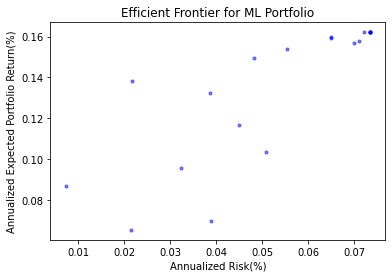

In [429]:
NoPoints = len(backtest_mean)

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for ML Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(backtest_mean * (trading_days_in_year /5), np.sqrt(backtest_var * (trading_days_in_year /5)), s=area, c=colours, alpha =0.5)
plt.show()

### MV Portfolio

In [ ]:
ms = np.arange(0.02, 0.1, 0.005)
mv_backtest_weights = pd.DataFrame(columns = ms)
mv_backtest_returns = pd.DataFrame(columns = ms)

for date in daterange:
  print(date)
  dataset = get_mv_dataset_for_date(date)
  r, cov = get_sample_return_and_covariance(dataset)
  weights = []
  rets = []
  for m in ms:
    weight = MinimizeRiskConstr(r, cov, 2, m)
    high_risk_weight = weight.x[0]
    ret = get_mv_backtest_return(date, high_risk_weight)
    weights.append(high_risk_weight)
    rets.append(ret)
  mv_backtest_weights.loc[date] = weights
  mv_backtest_returns.loc[date] = rets
  
  # a,b = train_and_get_a_b(dataset[:-1])  
  # with torch.no_grad():
  #   y_test = torch.exp(torch.matmul(torch.from_numpy(dataset[-1][:-1]), a)) / (torch.exp (torch.matmul(torch.from_numpy(dataset[-1][:-1]), a)) + torch.exp(torch.matmul(torch.from_numpy(dataset[-1][:-1]), b)))
  #   print(y_test)
  #   parameters.loc[date] = [a,b,y_test.numpy()]



2003-09-21 00:00:00


/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


2003-09-28 00:00:00
2003-10-05 00:00:00
2003-10-12 00:00:00
2003-10-19 00:00:00
2003-10-26 00:00:00


## Cross validation

In [38]:
# model = torch.exp(torch.matmul(x, a)) / (torch.exp (torch.matmul(x, a)) + torch.exp(torch.matmul(x, b)))

def train_epoch(dataloader):
    train_loss,train_correct=0.0,0
    for data in dataloader:

        x = data[:,:-1]
        y = data[:,-1]

        y_output = torch.exp(torch.matmul(x, a)) / (torch.exp (torch.matmul(x, a)) + torch.exp(torch.matmul(x, b)))
        loss = loss_fn(y_output, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item() * x.size(0)

    return train_loss
  
def valid_epoch(dataloader):

    valid_loss, val_correct = 0.0, 0
    for data in dataloader:

        x = data[:,:-1]
        y = data[:,-1]

        y_output = torch.exp(torch.matmul(x, a)) / (torch.exp (torch.matmul(x, a)) + torch.exp(torch.matmul(x, b)))

        loss = loss_fn(y_output, y)

        valid_loss+=loss.item() * x.size(0)

    return valid_loss

In [39]:
history = {'train_loss': [], 'test_loss': []}
 
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    for epoch in range(n_epochs):
        train_loss=train_epoch(train_loader)
        test_loss=valid_epoch(test_loader)

        train_loss = train_loss / len(train_loader.sampler)
        test_loss = test_loss / len(test_loader.sampler)

        if epoch % 1 == 0:
            print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f}".format(epoch + 1,n_epochs,train_loss,test_loss))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)

Fold 1


NameError: ignored

In [ ]:
print(a, b)

## Build efficient frontier

In [ ]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(X_tensor, a)) / (torch.exp (torch.matmul(X_tensor, a)) + torch.exp(torch.matmul(X_tensor, b)))
  print(y_test)

### Build ML Portfolio

In [ ]:
prob = pd.DataFrame(y_test).astype("float")
display(prob)
rolling_prob = prob.rolling(25).mean().iloc[-1]
display(rolling_prob.to_numpy()[0])

In [ ]:
def calculate_ml_portfolio_weights(x, k):
  return 0 if x < k else 1

for k in np.arange(0, 1, 0.1):
  print(calculate_ml_portfolio_weights(rolling_prob.to_numpy()[0], k))

In [ ]:
k = 0.5
calculate_ml_portfolio_weights_lambda = lambda x: 0 if x < k else 1
calculate_ml_portfolio_weights = np.vectorize(calculate_ml_portfolio_weights_lambda)
# vfunc(x)
# calculate_ml_portfolio_weights = functorch.vmap(ml_portfolio_weights, out_dims=1)
# forecast = 
# portfolio_weights = calculate_ml_portfolio_weights(y_test.numpy())
# print(portfolio_weights)

portfolio_weights = y_test.apply_(calculate_ml_portfolio_weights_lambda)
print(portfolio_weights)

In [ ]:
Xt = torch.from_numpy(to_X_train_features(low_risk, high_risk).T[-1])
Xt

In [ ]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(Xt, a)) / (torch.exp (torch.matmul(Xt, a)) + torch.exp(torch.matmul(Xt, b)))
  print(y_test)

In [ ]:
k = 0.5
calculate_ml_portfolio_weights_lambda = lambda x: 0 if x < k else 1
calculate_ml_portfolio_weights = np.vectorize(calculate_ml_portfolio_weights_lambda)

portfolio_weights = y_test.apply_(calculate_ml_portfolio_weights_lambda)
print(portfolio_weights)

# MV Portfolio

In [325]:
def add_daily_return(market_data):
    market_data["Pct Return"]  = market_data['Close'].pct_change()

add_daily_return(high_risk)
add_daily_return(low_risk)

In [326]:
high_risk

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Next Close,ROE,ROE Binary,Pct Return
25,2002-09-04,88.610001,90.250000,88.059998,89.540001,60.436001,0.550024,0.479605,0.276737,88.779999,-0.008488,0,NaN
26,2002-09-05,88.489998,89.430000,87.500000,88.779999,59.923054,0.723874,0.149555,0.229367,90.000000,0.013742,1,-0.008488
27,2002-09-06,89.750000,90.570000,89.339996,90.000000,60.746498,0.415721,0.128926,0.522307,90.660004,0.007333,1,0.013742
28,2002-09-09,89.099998,91.349998,88.800003,90.660004,61.191929,0.365951,0.804501,0.929931,91.699997,0.011471,1,0.007333
29,2002-09-10,91.139999,91.779999,90.559998,91.699997,61.893936,0.445799,0.288793,1.338801,91.129997,-0.006216,0,0.011471
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,2022-12-30,380.640015,382.579987,378.429993,382.429993,382.429993,0.903889,0.923099,-1.149319,380.820007,-0.004210,1,-0.002634
5143,2023-01-03,384.369995,386.429993,377.829987,380.820007,380.820007,0.805676,-1.830743,-1.654172,383.760010,0.007720,1,-0.004210
5144,2023-01-04,383.179993,385.880005,380.000000,383.760010,383.760010,0.924976,0.299117,-1.185467,379.380005,-0.011413,0,0.007720
5145,2023-01-05,381.720001,381.839996,378.760010,379.380005,379.380005,0.828493,-1.206745,-1.374945,388.079987,0.022932,1,-0.011413


In [327]:
high_risk_return_annual = high_risk["Pct Return"].mean() * trading_days_in_year
low_risk_return_annual = low_risk["Pct Return"].mean() * trading_days_in_year
print(high_risk_return_annual)
print(low_risk_return_annual)

0.09088309481924065
0.009396836284394002


In [328]:
high_risk_var_daily = high_risk["Pct Return"].var()
low_risk_var_daily = low_risk["Pct Return"].var()
print(high_risk_var_daily)
print(low_risk_var_daily)

0.00014831962827593315
1.840738816881264e-05


## Build data for high and low risk

In [329]:
mv_data = pd.DataFrame(data={'high': high_risk['Close'], 'low':low_risk['Close']})
mv_data

,high,low
25,89.540001,85.199997
26,88.779999,85.540001
27,90.000000,84.879997
28,90.660004,84.760002
29,91.699997,85.059998
...,...,...
5142,382.429993,95.779999
5143,380.820007,96.529999
5144,383.760010,97.269997
5145,379.380005,97.129997


In [331]:
r, cov = get_annual_sample_return_and_covariance(mv_data)
display(r)
display(cov)

high    0.090883
low     0.009397
dtype: float64

,high,low
high,0.037377,-0.004467
low,-0.004467,0.004639


In [332]:
def get_sample_return_and_covariance(data):
    daily_return = data.pct_change().mean()
    daily_covariance = data.pct_change().cov()
    return daily_return, daily_covariance

In [333]:
r, cov = get_sample_return_and_covariance(mv_data)
display(r)
display(cov)

high    0.000361
low     0.000037
dtype: float64

,high,low
high,0.000148,-0.000018
low,-0.000018,0.000018


## Optimization using linear programming

(Reference: https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios)


In [334]:
TERMINATION = 10**-9

In [335]:
#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
    #dependencies
    from scipy.optimize import linprog
    import numpy as np
    
    c = (np.multiply(-1, MeanReturns))
    A = np.ones([PortfolioSize,1]).T
    b=[1] 
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
    return res

In [336]:
#function obtains minimal risk portfolio 

from scipy import optimize 

def MinimizeRisk(CovarReturns, PortfolioSize):
    
    def  f(x, CovarReturns):
        func = np.matmul(np.matmul(x, CovarReturns), x.T) 
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = TERMINATION)
    
    return opt

In [337]:
def print_min_variance_portfolio(mean_returns, cov_returns):
    number_of_assets = len(mean_returns)
    result = MinimizeRisk(cov_returns, number_of_assets)

    print()
    minRiskWeights = result.x
    minRiskExpPortfolioReturn = np.matmul(mean_returns.T, minRiskWeights)
    print("Expected Return of Minimum Risk Portfolio:  %7.6f" % minRiskExpPortfolioReturn)
    minRisk = np.matmul(np.matmul(minRiskWeights, cov_returns), minRiskWeights.T) 
    print("Variance of Minimum Risk Portfolio : %7.6f" % minRisk)
    print("S.D. of Minimum Risk Portfolio : %7.6f" % np.sqrt(minRisk))
    threshold = 1e-3
    print("Weights (showing only those > %.6f): " % threshold)
    for i in range(0, number_of_assets):
        if result.x[i] > threshold:
            print(f"{mean_returns.index[i]}\t{result.x[i]:.6f}")
    print('Assets Considered:')
    print(mean_returns.index.to_numpy())

In [338]:
#function obtains Minimal risk and Maximum return portfolios

#dependencies
import numpy as np
from scipy import optimize 

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = TERMINATION)
    
    return  opt

In [339]:
print_min_variance_portfolio(r, cov)


Expected Return of Minimum Risk Portfolio:  0.000095
Variance of Minimum Risk Portfolio : 0.000012
S.D. of Minimum Risk Portfolio : 0.003457
Weights (showing only those > 0.001000): 
high	0.178717
low	0.821283
Assets Considered:
['high' 'low']


In [340]:
#Maximal expected portfolio return computation for the k-portfolio
result1 = MaximizeReturns(r, 2)
maxReturnWeights = result1.x
maxExpPortfolioReturn = np.matmul(r.T, maxReturnWeights)
print("Maximal Expected Portfolio Return:   %7.6f" % maxExpPortfolioReturn )

Maximal Expected Portfolio Return:   0.000361


In [341]:
#expected portfolio return computation for the minimum risk k-portfolio 
result2 = MinimizeRisk(cov, 2)
minRiskWeights = result2.x
minRiskExpPortfolioReturn = np.matmul(r.T, minRiskWeights)
print("Expected Return of Minimum Risk Portfolio:  %7.6f" % minRiskExpPortfolioReturn)

Expected Return of Minimum Risk Portfolio:  0.000095


In [342]:
#compute efficient set for the maximum return and minimum risk portfolios
increment = 0.000001
low = minRiskExpPortfolioReturn
high = maxExpPortfolioReturn

#initialize optimal weight set and risk-return point set
xOptimal =[]
minRiskPoint = []
expPortfolioReturnPoint =[]

#repeated execution of function MinimizeRiskConstr to determine the efficient set 
while (low < high):
    
    result3 = MinimizeRiskConstr(r, cov, 2, low)
    xOptimal.append(result3.x)
    expPortfolioReturnPoint.append(low)
    low = low+increment
    
#gather optimal weight set    
xOptimalArray = np.array(xOptimal)

#obtain annualized risk for the efficient set portfolios 
#for trading days = 251
minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,cov)),\
                                     np.transpose(xOptimalArray)))
riskPoint =   np.sqrt(minRiskPoint*trading_days_in_year) 

#obtain expected portfolio annualized return for the 
#efficient set portfolios, for trading days = 251
retPoint = trading_days_in_year*np.array(expPortfolioReturnPoint) 

#display efficient set portfolio parameters
print("Size of the  efficient set:", xOptimalArray.shape )
print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[riskPoint, retPoint])

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Size of the  efficient set: (266, 2)
Optimal weights of the efficient set portfolios: 
 [[0.19147597 0.80852403]
 [0.19303935 0.80696065]
 [0.19949414 0.80050586]
 [0.20124187 0.79875813]
 [0.20309764 0.79690236]
 [0.20505857 0.79494143]
 [0.20712071 0.79287929]
 [0.2092793  0.7907207 ]
 [0.21152886 0.78847114]
 [0.21386345 0.78613655]
 [0.21627678 0.78372322]
 [0.21876244 0.78123756]
 [0.23163842 0.76836158]
 [0.23388388 0.76611612]
 [0.23618429 0.76381571]
 [0.23892453 0.76107547]
 [0.24130016 0.75869984]
 [0.24372328 0.75627672]
 [0.24619299 0.75380701]
 [0.24870346 0.75129654]
 [0.25122177 0.74877823]
 [0.25381337 0.74618663]
 [0.2564398  0.7435602 ]
 [0.25909879 0.74090121]
 [0.26179442 0.73820558]
 [0.2645222  0.7354778 ]
 [0.26727472 0.73272528]
 [0.27005015 0.72994985]
 [0.27284665 0.72715335]
 [0.27566273 0.72433727]
 [0.27849678 0.72150322]
 [0.28134749 0.71865251]
 [0.28421348 0.71578652]
 [0.28709361 0.71290639]
 [0.28998677 0.71001323]
 [0.29319427 0.70680573]
 [0.29580812

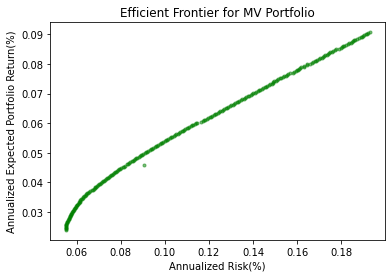

In [343]:
#Graph Efficient Frontier

NoPoints = riskPoint.size

colours = "green"
area = np.pi*3

plt.title('Efficient Frontier for MV Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(riskPoint, retPoint, s=area, c=colours, alpha =0.5)
plt.show()

# Naive Portfolio

In [344]:
naive_risks = []
naive_returns = []

for x in np.arange(0, 1, 0.01):
  weights = [x, 1-x]
  risk = np.matmul((np.matmul(weights,cov)),np.transpose(weights)) * trading_days_in_year
  naive_risks.append(np.sqrt(risk))

  #obtain expected portfolio annualized return for the 
  #efficient set portfolios, for trading days = 251
  ret = trading_days_in_year*(np.matmul(weights,r))
  naive_returns.append(ret)

#display efficient set portfolio parameters
# print("Size of the  efficient set:", xOptimalArray.shape )
# print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[naive_risks, naive_returns])

Annualized Risk and Return of the efficient set portfolios: 
 [[0.06810772 0.00939684]
 [0.06679558 0.0102117 ]
 [0.06553492 0.01102656]
 [0.06432878 0.01184142]
 [0.06318029 0.01265629]
 [0.06209263 0.01347115]
 [0.06106907 0.01428601]
 [0.06011286 0.01510087]
 [0.05922729 0.01591574]
 [0.05841555 0.0167306 ]
 [0.05768077 0.01754546]
 [0.05702592 0.01836032]
 [0.05645379 0.01917519]
 [0.0559669  0.01999005]
 [0.0555675  0.02080491]
 [0.0552575  0.02161978]
 [0.05503839 0.02243464]
 [0.05491126 0.0232495 ]
 [0.05487677 0.02406436]
 [0.05493507 0.02487923]
 [0.05508588 0.02569409]
 [0.05532844 0.02650895]
 [0.05566154 0.02732381]
 [0.05608358 0.02813868]
 [0.05659257 0.02895354]
 [0.05718619 0.0297684 ]
 [0.05786182 0.03058326]
 [0.05861664 0.03139813]
 [0.05944763 0.03221299]
 [0.06035164 0.03302785]
 [0.06132544 0.03384271]
 [0.06236577 0.03465758]
 [0.06346934 0.03547244]
 [0.06463293 0.0362873 ]
 [0.06585336 0.03710216]
 [0.06712751 0.03791703]
 [0.06845239 0.03873189]
 [0.06982512 

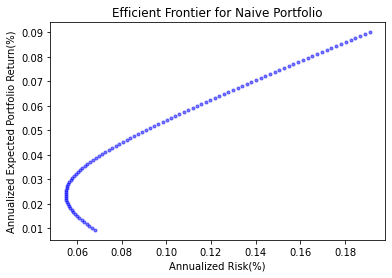

In [345]:
NoPoints = len(naive_risks)

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(naive_risks, naive_returns, s=area, c=colours, alpha =0.5)
plt.show()

# Combined Graph

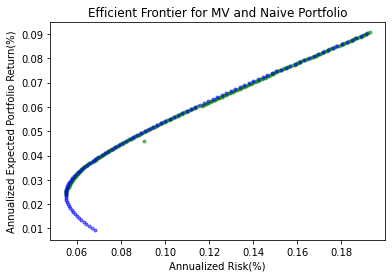

In [346]:
NoPoints = riskPoint.size

colours = "blue"
area = np.pi*3


fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.title('Efficient Frontier for MV and Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
ax1.scatter(riskPoint, retPoint, s=area, c="green", alpha =0.5)
ax1.scatter(naive_risks, naive_returns, s=area, c="blue", alpha =0.5)
# plt.xlim(riskPoint.min(), riskPoint.max())
plt.show()

In [347]:
cov

,high,low
high,0.000148,-0.000018
low,-0.000018,0.000018


In [348]:
print(high_risk["Close"].var())
print(high_risk["Close"].var() * trading_days_in_year)
print(high_risk["Close"].pct_change().var())
print(high_risk["Close"].pct_change().var() * trading_days_in_year)
print(np.sqrt(high_risk["Close"].pct_change().var() * trading_days_in_year))

9864.007665920406
2485729.9318119423
0.00014831962827593315
0.03737654632553515
0.19333014851681862
